# **Real-Time Fraud Detection System** 


---

### **Description**

This project implements a **real-time fraud detection system** using **Apache Spark Streaming, MLlib** & **GraphFrames**, **Apache Kafka**, **Apache Nifi** and **HDFS**. The system ingests live transaction data and processes it using using a pre-trained ML model to classify transactions as Fraud or not. Beyond this, the system also identifies any Suspicious Activity within a window of time & highlights transactions indicating the presence of Money Laundering Rings.


### Key Features
- **Real-Time Data Ingestion**
  - Uses Apache NiFi to ingest live transaction data coming from custom Mockaroo API.
  - The API is designed to return a single transaction in the form of a JSON document for every HTTP Get Request.
- **Streaming Data Storage**
  - Uses Apache Kafka to store Incoming Transactions data in a newly created topic
- **Data Processing**
  - Apache Spark as a consumer reads the stream of events in Kafka to import the data
  - The imported data, which is in the form of JSON objects, is parsed into a Spark DataFrame for further use
- **Business Application I - Machine Learning for Fraud Detection**
  - The pre-tained Random Forest Classifier, Vector Assembler & String Indexer, in the form of a Pipeline Object, are imported from HDFS.
  - The pipeline then make Fraud predictions micro-batches of the streaming data every 10 seconds(trigger).
  - Predictions are printed on the Console.
- **Business Application II - Identifying Suspicious Activity**
  - A Window of 10 mins sliding every 5 mins is defined
  - Incoming data in categorised in the windows & Customers with more than 5 transactions within this time period are isolated as Suspicious.
- **Business Application III - Identifying Money Laundering Rings**
  - Senders & Receivers are categorised as vertices & transactions as the edges
  - GraphFrames are used to find transactions of the form of A --> B --> .... --> A
  - Such identifed transactions are then printed on the console.

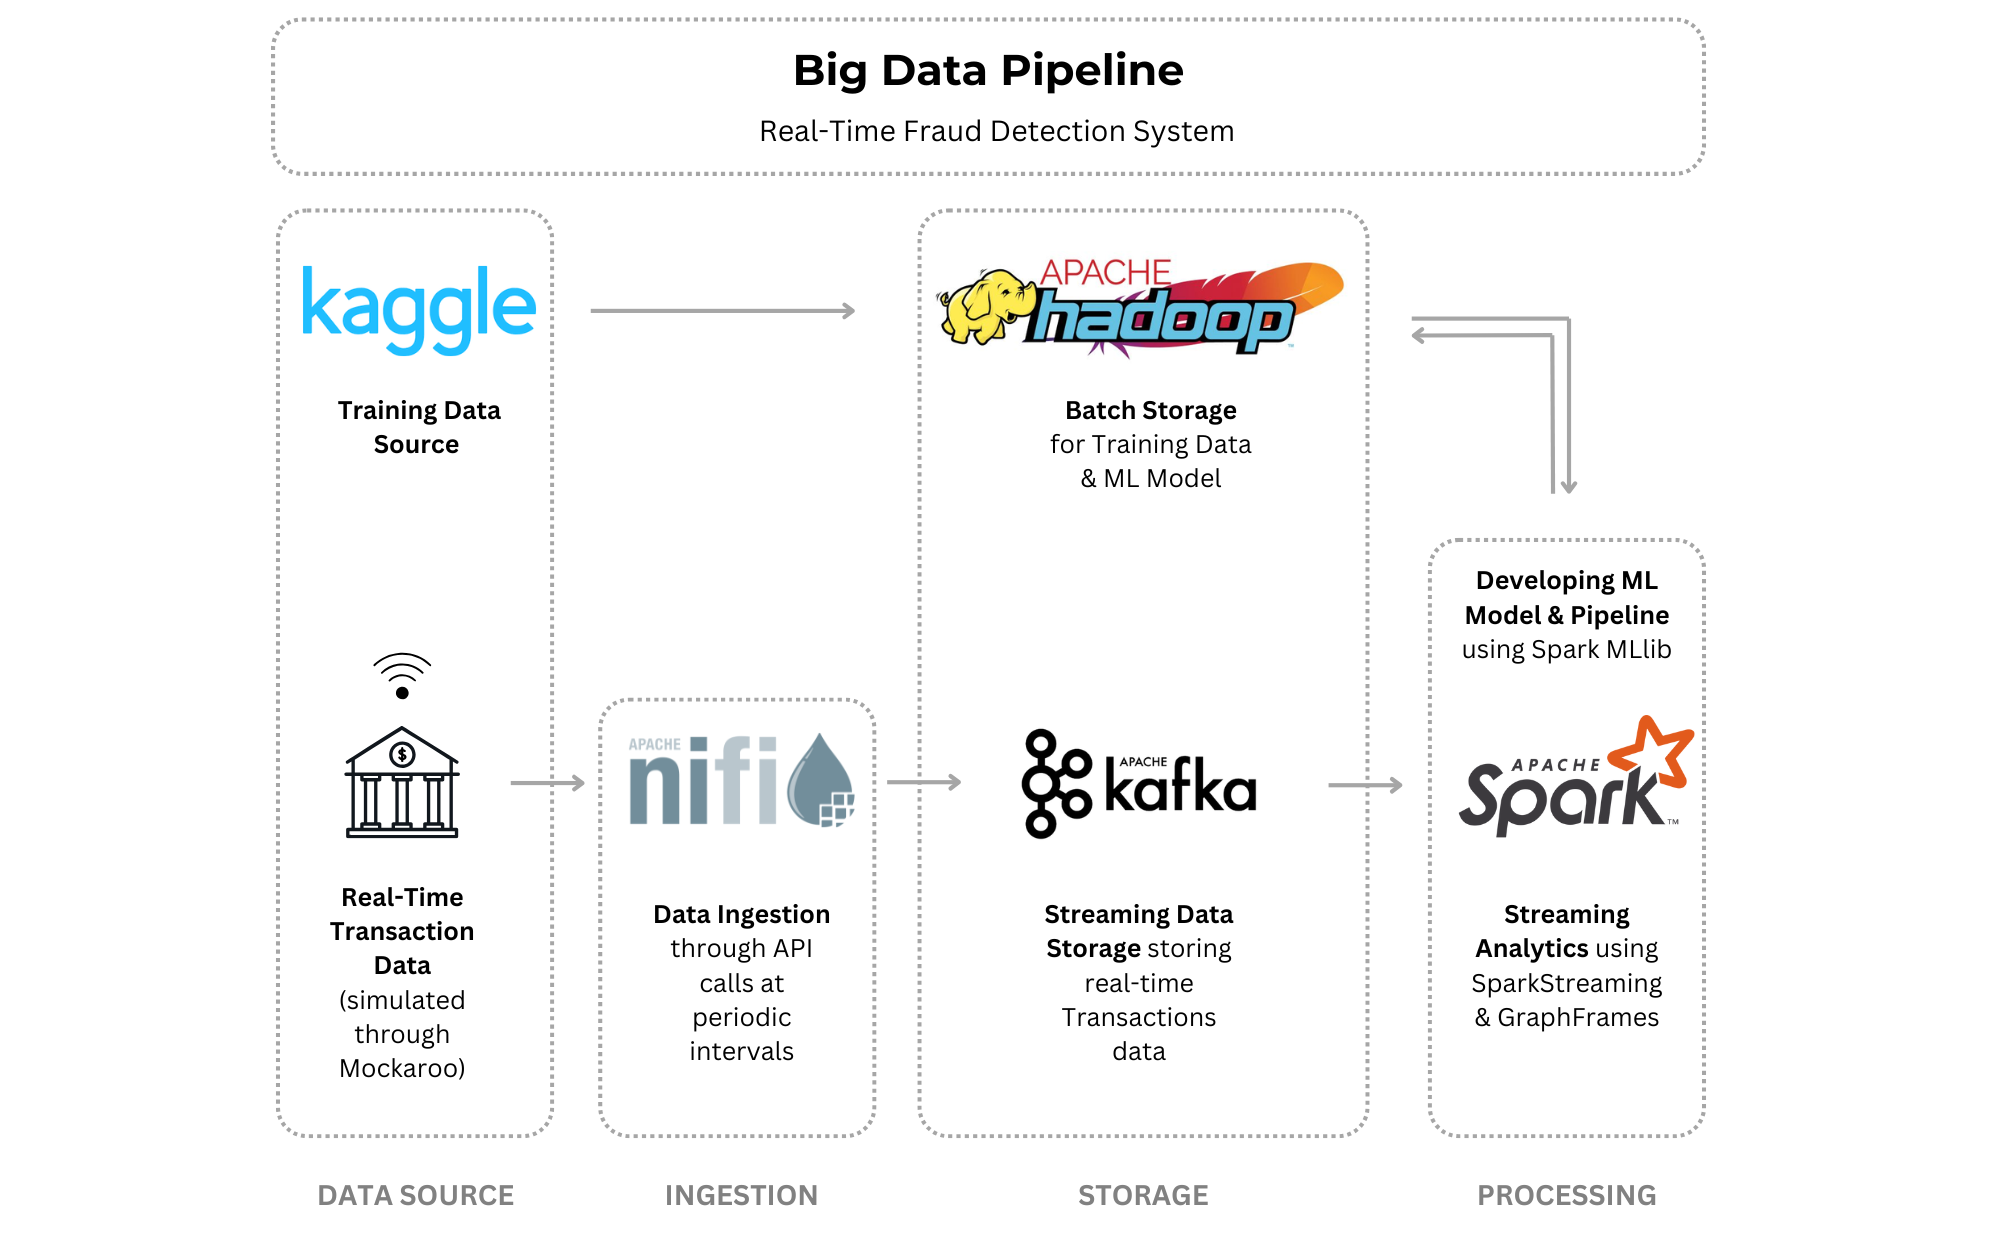

### **Notebook Environment Setup**

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F 
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.ml import PipelineModel
from pyspark.ml.feature import StringIndexerModel
import pandas as pd
import os
from graphframes import GraphFrame

In [3]:
#importing kafka & graphFrame connector module

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.2,graphframes:graphframes:0.8.3-spark3.5-s_2.12" pyspark-shell'

In [4]:
#creating the Spark session

spark = SparkSession.builder \
    .appName("Real-Time Fraud Detection- MDA2 Group Assignment") \
    .getOrCreate()
print(f"This cluster relies on Spark '{spark.version}'")

25/03/08 11:08:04 WARN Utils: Your hostname, osbdet resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s1)
25/03/08 11:08:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/osbdet/.jupyter_venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d0f2cf5e-9428-456c-9253-4ac8564eba28;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.2 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.2 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
	found graphfram

This cluster relies on Spark '3.5.0'


### **Data Preprocessing**

In [5]:
#creating & loading data from transactions topic of kafka to a dataFrame using streamReader

event_dataframe = \
          spark.readStream\
               .format("kafka") \
               .option("kafka.bootstrap.servers", "localhost:9092") \
               .option("subscribe", "Transactions") \
               .option("startingOffsets", "earliest") \
               .load()

event_dataframe.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [6]:
#casting the value column to String for further manipulation

event_dataframe = \
  event_dataframe.select(F.col("value").cast(StringType()))

event_dataframe.printSchema()

root
 |-- value: string (nullable = true)



In [7]:
#extracting each column's data from the JSON Object in each row

data = \
    event_dataframe.withColumn("type", F.get_json_object("value", '$.type').cast(StringType()))\
                 .withColumn("amount",F.get_json_object("value", '$.amount').cast(DoubleType()))\
                 .withColumn("nameOrig", F.get_json_object("value", '$.nameOrig').cast(StringType()))\
                 .withColumn("oldbalanceOrg", F.get_json_object("value", '$.oldbalanceOrg').cast(DoubleType()))\
                 .withColumn("newbalanceOrig", F.get_json_object("value", '$.newbalanceOrig').cast(DoubleType()))\
                 .withColumn("nameDest", F.get_json_object("value", '$.nameDest').cast(StringType()))\
                 .withColumn("oldbalanceDest",F.get_json_object("value", '$.oldbalanceDest').cast(DoubleType()))\
                 .withColumn("newbalanceDest", F.get_json_object("value", '$.newbalanceDest').cast(DoubleType()))\
                 .withColumn("timestamp", F.to_timestamp(F.from_unixtime(F.get_json_object("value", '$.unix_time'))))\
                 .drop("value")

data.printSchema()

root
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [8]:
model_data = data.drop("timestamp")

In [9]:
model_data = model_data.withColumn("balance_change_orig", F.col("oldbalanceOrg") - F.col("newbalanceOrig")) \
                   .withColumn("balance_change_dest", F.col("newbalanceDest") - F.col("oldbalanceDest")) \
                   .withColumn("dest_balance_zero", F.when(F.col("oldbalanceDest") == 0, 1).otherwise(0)) \
                   .withColumn("is_large_transaction", F.when(F.col("amount") > 10000, 1).otherwise(0))

In [10]:
model_data.printSchema()

root
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- balance_change_orig: double (nullable = true)
 |-- balance_change_dest: double (nullable = true)
 |-- dest_balance_zero: integer (nullable = false)
 |-- is_large_transaction: integer (nullable = false)



### **Business Application I - Machine Learning for Fraud Detection**
Using the previously trained Random Forest model, String Indexer & Vector Assembler to predict the likelihood of a transaction being Fraud. Transactions which are likely to be Fraud are classified as 1 & not-Fraud are classified as 0 based on the probabilities assigned by the ML model.

In [11]:
#loading the StringIndexer & transforming the categorical column

indexer = StringIndexerModel.load("hdfs://localhost:9000/datalake/raw/fraud-detection/String_Indexer")

model_data = indexer.transform(model_data)
model_data = model_data.drop("type")
model_data = model_data.dropna()

In [12]:
#fitting the streaming data into the Vector Assembler & ML Model through Pipeline object

classifierPipeline = PipelineModel.load("hdfs://localhost:9000/datalake/raw/fraud-detection/Classifier_Pipeline")


predictions = classifierPipeline.transform(model_data)
predictions = predictions.select("nameOrig","nameDest", "amount", "prediction")

In [13]:
#writing predictions to the console sink

console_sink = predictions.writeStream\
                            .format("console")\
                            .outputMode("append")\
                            .trigger(processingTime='10 seconds')

In [16]:
ap = console_sink.start()

25/03/07 20:19:00 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-894a2493-02c9-4767-a7c0-7878bcf9928a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/03/07 20:19:00 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/03/07 20:19:00 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 0
-------------------------------------------
+-----------+-----------+-------------+----------+
|   nameOrig|   nameDest|       amount|prediction|
+-----------+-----------+-------------+----------+
| M408069119|M1979787155|   8175249.12|       0.0|
| C154988899| M408069119|3.843616537E7|       1.0|
|  C90045638|M1230701703|5.650184589E7|       1.0|
|  C38997010|M1979787155|    114193.47|       0.0|
| C195600860|M1176932104|5.824704652E7|       0.0|
| C840083671| C553264065|8.521109738E7|       0.0|
|C2048537720| M408069119|6.053496208E7|       0.0|
| C712410124|M1979787155|5.661421424E7|       0.0|
|  C90045638| M573487274|   8745769.73|       0.0|
| C712410124| M408069119|5.737888833E7|       1.0|
|C2048537720|M1230701703| 5.59799267E7|       1.0|
| M633326333| M573487274|3.312188169E7|       0.0|
|C1305486145|M2044282225|5.035059648E7|       0.0|
|C1305486145|M1979787155|8.776619488E7|       1.0|
| C553264065|M1176932104|8.445921444

-------------------------------------------
Batch: 1
-------------------------------------------
+---------+-----------+-------------+----------+
| nameOrig|   nameDest|       amount|prediction|
+---------+-----------+-------------+----------+
|C90045638|M2044282225|5.466266957E7|       0.0|
+---------+-----------+-------------+----------+

-------------------------------------------
Batch: 2
-------------------------------------------
+-----------+----------+-------------+----------+
|   nameOrig|  nameDest|       amount|prediction|
+-----------+----------+-------------+----------+
| C154988899|C195600860|6.993887981E7|       0.0|
|M2044282225|C195600860|8.979474396E7|       0.0|
+-----------+----------+-------------+----------+



In [17]:
ap.stop()

### **Business Application II - Identifying Suspicious Activity**
Any customer engaging in more than 6 transactions within a period of 10 minutes is categorised as Suspicious. So, 10 minute sliding windows, rolling every 5 minutes, are used to filter out such Suspicious Activities for further inspection.

<center> 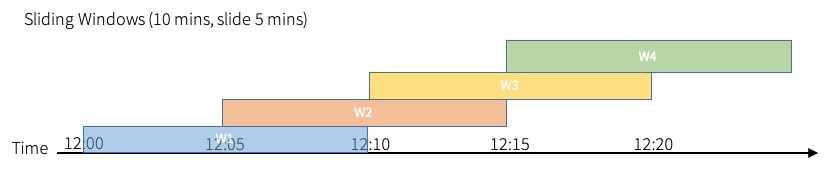 </center>

In [14]:
#categorising the incoming stream of data into 10 minute sliding windows & filtering accounts with greater than 5 transactions in a single window

suspicious_activity = data \
    .groupBy(F.window(F.col("timestamp"), "10 minutes", "5 minutes"), F.col("nameOrig")) \
    .agg(F.count("*").alias("transaction_count")) \
    .filter(F.col("transaction_count") > 6)

In [17]:
#writing the output to console sink

console_sink = suspicious_activity.writeStream \
    .outputMode("update") \
    .format("console")\
    .trigger(processingTime='10 seconds')

In [18]:
ap = console_sink.start()

25/03/08 11:12:03 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-7cea7a19-1e93-4d2f-a126-6f3791f63f54. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/03/08 11:12:03 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/03/08 11:12:04 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 0
-------------------------------------------
+--------------------+-----------+-----------------+
|              window|   nameOrig|transaction_count|
+--------------------+-----------+-----------------+
|{+57133-05-09 01:...| C553264065|                7|
|{+57133-05-09 02:...|  C90045638|                9|
|{+57133-05-09 01:...|  C90045638|                9|
|{+57133-05-09 02:...|M2044282225|                8|
|{+57133-05-09 01:...|M2044282225|                8|
|{+57133-05-09 02:...|C2048537720|               10|
|{+57133-05-09 01:...|C2048537720|               10|
|{+57133-05-09 02:...| C553264065|                7|
+--------------------+-----------+-----------------+



-------------------------------------------
Batch: 1
-------------------------------------------
+------+--------+-----------------+
|window|nameOrig|transaction_count|
+------+--------+-----------------+
+------+--------+-----------------+



-------------------------------------------
Batch: 2
-------------------------------------------
+------+--------+-----------------+
|window|nameOrig|transaction_count|
+------+--------+-----------------+
+------+--------+-----------------+



In [19]:
ap.stop()

### **Business Application III - Identifying Potential Money Laundering Rings**
Any transaction initiated from point A, going through a number of other accounts and terminating back at the same account without any material change in value is classified as a potential fraud ring. Such transactions are identified using GraphFrames where Senders & Receivers are considered as vertices & transactions as the edges. An example of such a circular flow of money is highlighted in red in the below illustration.

<img 
src="https://miro.medium.com/v2/resize:fit:1400/1*kK_Hf96Wo42vj3kFSaLVyQ.png"
/>

In [20]:
#creating vertices using UserIDs of Senders & Receivers

vertices = data.select(F.col("nameOrig").alias("id")).distinct() \
    .union(data.select(F.col("nameDest").alias("id")).distinct())

In [21]:
#creating edges (money transfers between users)

edges = data.select(
    F.col("nameOrig").alias("src"),
    F.col("nameDest").alias("dst"),
    F.col("amount")
)

In [22]:
#creating the GraphFrame instance

g = GraphFrame(vertices, edges)

/home/osbdet/.jupyter_venv/lib/python3.11/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [23]:
#finding Money Laundering Cycles

fraud_rings = g.find("(a)-[e]->(b); (b)-[e2]->(c); (c)-[e3]->(a)")

/home/osbdet/.jupyter_venv/lib/python3.11/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [24]:
console_sink = fraud_rings.writeStream \
                                  .outputMode("append") \
                                  .format("console")\
                                  .trigger(processingTime='10 seconds')

In [25]:
ap = console_sink.start()

25/03/08 11:12:42 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-a6e27290-896a-40b3-8fa4-f8bcb927c6ec. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/03/08 11:12:42 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/03/08 11:12:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 0
-------------------------------------------
+-------------+--------------------+------------+--------------------+------------+--------------------+
|            a|                   e|           b|                  e2|           c|                  e3|
+-------------+--------------------+------------+--------------------+------------+--------------------+
|{M2044282225}|{M2044282225, C55...|{C553264065}|{C553264065, C553...|{C553264065}|{C553264065, M204...|
|{M2044282225}|{M2044282225, C55...|{C553264065}|{C553264065, C553...|{C553264065}|{C553264065, M204...|
|{M2044282225}|{M2044282225, C55...|{C553264065}|{C553264065, C553...|{C553264065}|{C553264065, M204...|
|{M2044282225}|{M2044282225, C55...|{C553264065}|{C553264065, C553...|{C553264065}|{C553264065, M204...|
|{M2044282225}|{M2044282225, C55...|{C553264065}|{C553264065, C553...|{C553264065}|{C553264065, M204...|
|{M2044282225}|{M2044282225, C55...|{C553264065}|{C553264065, C

25/03/08 11:13:43 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 60585 milliseconds
25/03/08 11:14:35 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 52066 milliseconds


-------------------------------------------
Batch: 1
-------------------------------------------
+------------+--------------------+------------+--------------------+-------------+--------------------+
|           a|                   e|           b|                  e2|            c|                  e3|
+------------+--------------------+------------+--------------------+-------------+--------------------+
|{M573487274}|{M573487274, C553...|{C553264065}|{C553264065, M117...|{M1176932104}|{M1176932104, M57...|
|{M573487274}|{M573487274, C553...|{C553264065}|{C553264065, M117...|{M1176932104}|{M1176932104, M57...|
|{M573487274}|{M573487274, C553...|{C553264065}|{C553264065, M117...|{M1176932104}|{M1176932104, M57...|
|{M573487274}|{M573487274, C553...|{C553264065}|{C553264065, M117...|{M1176932104}|{M1176932104, M57...|
|{M573487274}|{M573487274, C553...|{C553264065}|{C553264065, M117...|{M1176932104}|{M1176932104, M57...|
|{M573487274}|{M573487274, C553...|{C553264065}|{C553264065, M1

In [27]:
ap.stop()

### End of Notebook